In [5]:
import PyPlot; const plt = PyPlot
using ProgressMeter
using FileIO
using Logging
include("../src/DQMC.jl")
include("../src/KinecticReader.jl")
import Statistics

const dtype = ComplexF64

function signs(x::DQMCWalker, scheme)
    return x.individualWeight / abs(x.individualWeight), (x.individualWeight / abs(x.individualWeight))^(scheme.Nflavor)
end

signs (generic function with 1 method)

In [6]:
# debuglogger = ConsoleLogger(stderr, Logging.Debug)
debuglogger = ConsoleLogger(stderr, Logging.Info)
global_logger(debuglogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(47) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [12]:
function honeycombSpinresolvedQMC(M, U, deltaTau, thermalizationTime, iterationTime, refreshInterval, L)
    nx = L
    ny = L
    Δτ = deltaTau
    nflavor = 2
    
    p = Progress(thermalizationTime + iterationTime, 2)
    Nsites, Kinectic = BuildKinecticFromYAML("../src/hams/2dHoneycomb.yml", nx, ny, dtype)
    schemeSU2N = DQMCScheme{dtype}(Nsites, nflavor, M, Δτ, Kinectic)
    paramsAux = AuxFieldUpdaterParams{dtype}(U, schemeSU2N)
    x = initializeWalker(schemeSU2N, paramsAux, refreshInterval);

    for i in 1:thermalizationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        next!(p)
    end

    signInd = Vector{dtype}(undef, iterationTime)
    signTot = Vector{dtype}(undef, iterationTime)
    for i in 1:iterationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        signInd[i], signTot[i] = signs(x, schemeSU2N)
        next!(p)
    end

    signInd, signTot
end

honeycombSpinresolvedQMC (generic function with 1 method)

$L = 6 \times 6$ lattices, with $2 L^2 $ sites

In [18]:
tau = 0.1
# betas = [2, 3, 4, 5, 6, 7, 8, 12, 16, 32, 60] * tau
Ms = [2, 6, 16]
L = 6
U = 3.60

sign_list = []
sign_std_list = []
signtot_list = []

for M in Ms
    signInd, signTot = honeycombSpinresolvedQMC(M, U, tau, 200, 1000, 20, L)
    append!(sign_list, Statistics.mean(signInd))
    append!(signtot_list, Statistics.mean(signTot))
    append!(sign_std_list, Statistics.std(signInd) / sqrt(length(signInd)))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


In [19]:
signtot_list

3-element Vector{Any}:
 1.0 - 1.826940123977788e-15im
 1.0 + 1.2547568933287554e-14im
 1.0 + 5.323978013160111e-14im

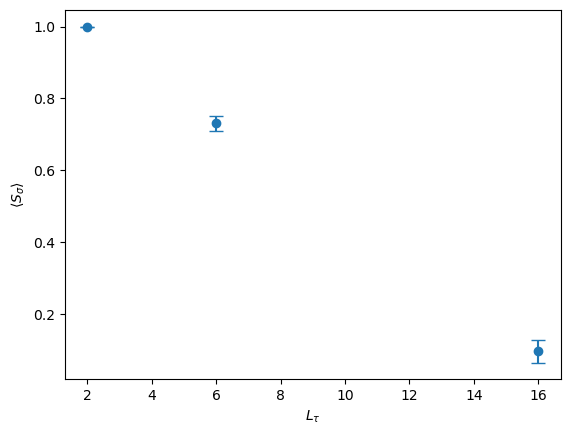

In [20]:
plt.errorbar(Ms, abs.(sign_list), yerr=abs.(sign_std_list), ls="none", marker="o", capsize=5)
plt.xlabel("\$ L_{\\tau}\$")
plt.ylabel("\$\\langle S_\\sigma \\rangle\$")
plt.show()